In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

In [ ]:
def data_info(direct):
  files = [file.strip() for file in os.listdir('./'+direct)]
  filenames = []
  for file in files:
    add = [file[:-4],file[0]]
    filenames.append(add)
  return filenames

In [ ]:
import os
import pandas as pd

def data_info(directory):
    files = [file.strip() for file in os.listdir(directory)]
    filenames = []
    for file in files:
        add = [file[:-4], file[0]]
        filenames.append(add)
    return pd.DataFrame(filenames, columns=['filename', 'label'])

# Specify the directories for train and test data
train_directory = '/content/drive/MyDrive/hackathon/train'
test_directory = '/content/drive/MyDrive/hackathon/test'

# Retrieve information for train and test data
df_train = data_info(train_directory)
df_test = data_info(test_directory)

# Create DataFrames for train and test
train = pd.DataFrame(df_train, columns=['filename', 'label'])
test = pd.DataFrame(df_test, columns=['filename', 'label'])

# Display the first few rows of the DataFrames
display(train.head(), test.head())


,filename,label
0,3 (7),3
1,2 (9),2
2,2 (3),2
3,2 (5),2
4,2 (4),2


,filename,label
0,36,3
1,50,5
2,43,4
3,4,4
4,41,4


In [ ]:
def pixel_info(direct, df):
  pixels = []
  for file in list(df['filename']):  # 각 이미지에 대해
    from PIL import Image
    im = Image.open('./'+direct+'/'+file+'.bmp')  # 이미지 불러오기
    pix = list(im.getdata())   # 각 이미지 픽셀값 계산
    pixels.append(pix)

  df_pix = pd.DataFrame(pixels, columns = list(range(144**2)))  # pixel data 담은 dataframe
  return df_pix

In [ ]:
from PIL import Image

def pixel_info(directory, dataframe):
    pixel_data = []
    for index, row in dataframe.iterrows():
        filename = os.path.join(directory, f"{row['filename']}.bmp")
        img = Image.open(filename)
        pixels = list(img.getdata())
        pixel_data.append(pixels)
    return pd.DataFrame(pixel_data)

# Specify the directories for train and test data
train_directory = '/content/drive/MyDrive/hackathon/train'
test_directory = '/content/drive/MyDrive/hackathon/test'

# Retrieve information for train and test data
df_train = data_info(train_directory)
df_test = data_info(test_directory)

# Create DataFrames for train and test
train = pd.DataFrame(df_train, columns=['filename', 'label'])
test = pd.DataFrame(df_test, columns=['filename', 'label'])

# Get pixel information for train and test data
train_pix = pixel_info(train_directory, train)
test_pix = pixel_info(test_directory, test)

In [ ]:
display(train_pix.head(), test_pix.head())

,0,1,2,3,4,5,6,7,8,9,...,20726,20727,20728,20729,20730,20731,20732,20733,20734,20735
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,20726,20727,20728,20729,20730,20731,20732,20733,20734,20735
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


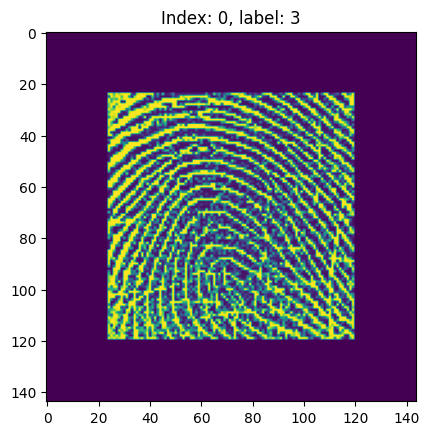

In [ ]:
idx = 0
img = train_pix.loc[idx, '0':].values.reshape(144, 144).astype(int)
label = train.loc[idx, 'label']

plt.title('Index: %i, label: %s'%(idx, label))
plt.imshow(img)
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_pix.values, train['label'], test_size = 0.3, random_state=42, shuffle=True, stratify=None)

X_train = X_train.reshape(-1, 144, 144, 1)
X_train = X_train/255

X_val = X_val.reshape(-1, 144, 144, 1)
X_val = X_val/255

X_test = test_pix.values.reshape(-1, 144, 144, 1)
X_test = X_test/255

# train/test label 값 one-hot-encoding
y_train_vec = np.zeros((len(y_train), 8))
for i, digit in enumerate(y_train):
    y_train_vec[int(i), int(digit)-1] = 1

y_val_vec = np.zeros((len(y_val), 8))
for i, digit in enumerate(y_val):
    y_val_vec[int(i), int(digit)-1] = 1

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

# 8개의 지문으로 분류
nb_classes = 8
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)


model = Sequential([
                  Conv2D(nb_filters, kernel_size[0], kernel_size[1], padding='valid', input_shape=X_train.shape[1:], activation = 'relu'),
                  Conv2D(nb_filters, kernel_size[0], kernel_size[1], activation = 'relu'),
                  MaxPooling2D(pool_size=pool_size),
                  Dropout(0.25),

                  Flatten(),
                  Dense(128, activation = 'relu'),
                  Dropout(0.5),
                  Dense(nb_classes, activation = 'softmax')
])

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer= 'adam' , metrics=['accuracy'])

In [ ]:
batch = 8
epoch = 10
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('./model/model_cnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train_vec, epochs=epoch, callbacks=[es, mc], batch_size=batch, validation_data=(X_val, y_val_vec))

Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 2.1178 - accuracy: 0.1071
Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to ./model/model_cnn.h5
7/7 [==============================] - 3s 97ms/step - loss: 2.1178 - accuracy: 0.1071 - val_loss: 2.0189 - val_accuracy: 0.3750
Epoch 2/10
4/7 [================>.............] - ETA: 0s - loss: 2.0063 - accuracy: 0.2500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 2.0262 - accuracy: 0.2500
Epoch 2: val_accuracy improved from 0.37500 to 0.41667, saving model to ./model/model_cnn.h5
7/7 [==============================] - 0s 41ms/step - loss: 2.0262 - accuracy: 0.2500 - val_loss: 1.9612 - val_accuracy: 0.4167
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 1.8540 - accuracy: 0.5893
Epoch 3: val_accuracy improved from 0.41667 to 0.70833, saving model to ./model/model_cnn.h5
7/7 [==============================] - 0s 45ms/step - loss: 1.8540 - accuracy: 0.5893 - val_loss: 1.8007 - val_accuracy: 0.7083
Epoch 4/10
6/7 [========================>.....] - ETA: 0s - loss: 1.7166 - accuracy: 0.6250
Epoch 4: val_accuracy did not improve from 0.70833
7/7 [==============================] - 0s 34ms/step - loss: 1.6973 - accuracy: 0.6250 - val_loss: 1.5855 - val_accuracy: 0.7083
Epoch 5/10
7/7 [==============================] - ETA: 0s - loss: 1.4589 - accuracy: 0.7500
Epoch 5: val_accuracy 

In [ ]:
from tensorflow.keras.models import load_model
best = load_model('./model/model_cnn.h5')

In [ ]:
val_predict = np.argmax(best.predict(X_val), axis=1)
print("\n Validation: %.4f" % (best.evaluate(X_val, y_val_vec)[1]))
print(classification_report(np.argmax(y_val_vec, axis=1),val_predict))

1/1 [==============================] - 0s 320ms/step - loss: 0.9740 - accuracy: 1.0000

 Validation: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [ ]:
test_predict = np.argmax(best.predict(X_test), axis=1)
true_class = [pred+1 for pred in test_predict]

test['label'] = true_class

3/3 [==============================] - 0s 13ms/step


In [ ]:
test['filename'] = pd.to_numeric(test["filename"])
test

,filename,label
0,36,8
1,50,8
2,43,8
3,4,8
4,41,7
...,...,...
75,53,8
76,54,4
77,48,3
78,49,5


In [ ]:
result = test.sort_values(by=['filename'], ascending=True)
result.head()

,filename,label
38,1,7
29,2,8
14,3,2
3,4,8
74,5,1


In [ ]:
from collections import Counter
Counter(result['label'])

Counter({7: 5, 8: 37, 2: 10, 1: 3, 5: 10, 3: 10, 6: 2, 4: 3})